# Imports

In [1]:
import time
import os,pickle
import numpy as np
from common import misc
from matplotlib import pyplot as plt
from scipy.special import ellipk,ellipe,j0
from scipy.integrate import quad,dblquad
from numba import njit
from common import numerical_recipes as numrec
from common.baseclasses import AWA
from common import plotting
from importlib import reload
from scipy.linalg import eig,eigh,svd

import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import RotationalMoM as RotMOM

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
	Registered colormaps "rainbow" and "rainbow_r"...
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


/Users/alexandersmcleod/tools/python/common/plotting.py:56: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  pyplot.register_cmap(name='BWR', data=cdict)
/Users/alexandersmcleod/tools/python/common/plotting.py:78: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  pyplot.register_cmap(name='BWR2', data=cdict)
/Users/alexandersmcleod/tools/python/common/plotting.py:100: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, l

# Build a Probe

In [2]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
taper_angle=35
Rtop=0
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=19e3/a_nm
freq_THz=a_nm/WL_THz_nm
freq=30*freq_THz

#-- Build probe

Nsubnodes=2
P=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                 a=1,taper_angle=taper_angle,geometry='hyperboloid',Rtop=Rtop,
            freq=freq,gap=1)

#-- probe attributes

gap=P.get_gap()
zsprobe=P.get_zs()
rsprobe=P.get_radii()
k=P.get_k()

<__init__.get_probe_radii>:
	Getting geometry for selection "hyperboloid"...
<RotationalMoM.Discretization.__init__>:
	Discretizing body of revolution over 244 annular nodes and 2 subnodes...


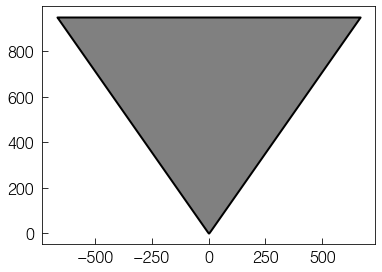

In [3]:
#-- Plot probe shape

plt.figure()
#plt.plot(-radii,zs,radii,zs,color='b')
xsprobe=np.append(-rsprobe[::-1],rsprobe)
ysprobe=np.append(zsprobe[::-1],zsprobe)
plt.fill_between(x=xsprobe,
                 y1=ysprobe,y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')

(-1.0, 5.0)

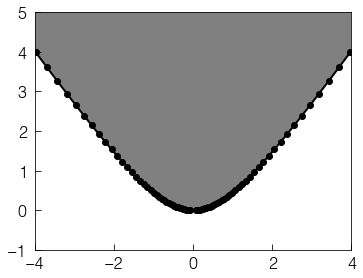

In [4]:
#-- Plot probe shape - zoom

plt.figure()
#plt.plot(-radii,zs,radii,zs,color='b')
plt.fill_between(x=xsprobe,
                 y1=ysprobe,y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.plot(xsprobe,ysprobe,marker='o',ls='',color='k')
plt.gca().set_aspect('equal')
plt.xlim(-4,4)
plt.ylim(-1,5)

## Solve eigenoscillations

<RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix...
	Progress: 99.59%	Total quadrature time: 2.61s, time per quadrature evaluation: 4.38E-05s
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.59%	Total quadrature time: 7.24s, time per quadrature evaluation: 1.22E-04s


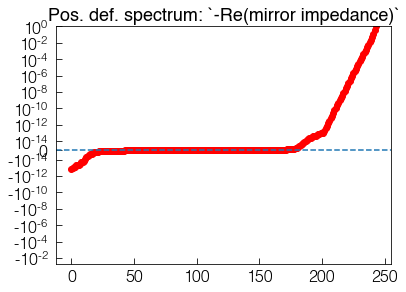

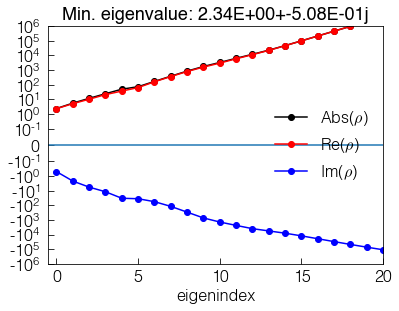

In [5]:
P.get_mirror_impedance(sommerfeld=False,k=0)
P.solve_eigenmodes(plot=True,condition_ZS=False)
P.plot_eigenrhos()

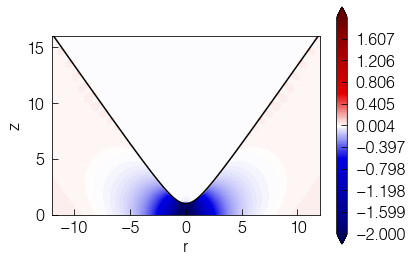

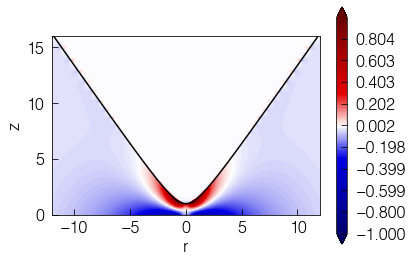

In [6]:
#--- Visualize the E-field from an eigenoscillation
#
# Computed in quasistatic approximation from exact electrodynamic charge solution
# Sums the probe field and the reflected eigenoscillation

n=1
Q=P.get_eigencharge(n)
eigenrho=P.get_eigenrho(n)
cl=2

at_rs=np.linspace(0,12,100)
at_zs=np.linspace(0,16,150)
Er,Ez=P.computeEfieldImages(Q, rho=eigenrho,
                            rs_out=at_rs, zs_out=at_zs,\
                            display=True,mirror_double_images=True)



plt.figure()
plt.plot(xsprobe,ysprobe+1,color='k')
plt.gca().set_aspect('equal')
Ez.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl,cl,500),extend='both')
plt.clim(-cl,cl)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

plt.figure()
plt.plot(xsprobe,ysprobe+1,color='k')
plt.gca().set_aspect('equal')
Er.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl/2,cl/2,500),extend='both')
plt.clim(-cl/2,cl/2)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

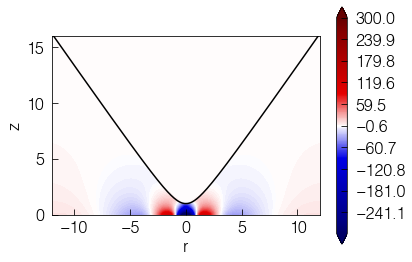

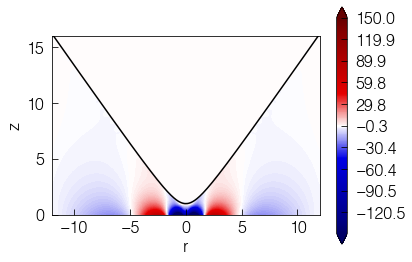

In [7]:
#--- Visualize the E-field from an eigenoscillation
#
# Computed in quasistatic approximation from exact electrodynamic charge solution
# Sums the probe field and the reflected eigenoscillation

n=7
Q=P.get_eigencharge(n)
eigenrho=P.get_eigenrho(n)
cl=300

at_rs=np.linspace(0,12,100)
at_zs=np.linspace(0,16,150)
Er,Ez=P.computeEfieldImages(Q, rho=eigenrho,
                            rs_out=at_rs, zs_out=at_zs,\
                            display=True,mirror_double_images=True)



plt.figure()
plt.plot(xsprobe,ysprobe+1,color='k')
plt.gca().set_aspect('equal')
Ez.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl,cl,500),extend='both')
plt.clim(-cl,cl)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

plt.figure()
plt.plot(xsprobe,ysprobe+1,color='k')
plt.gca().set_aspect('equal')
Er.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl/2,cl/2,500),extend='both')
plt.clim(-cl/2,cl/2)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

## Excite the probe, see induced charge and scattered field

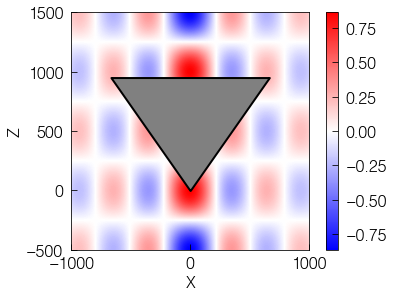

In [8]:
Er0,Ez0=PCE.EBesselBeamFF(angle=60, k = k)
#Zs,Xs=np.meshgrid(zs,xs)
Xs,Zs=np.ogrid[-1000:1000:1000j,
               -500:1500:1000j]; xs=Xs.squeeze(); zs=Zs.squeeze()
er0,ez0=Er0(Xs,Zs),Ez0(Xs,Zs)
ez0=AWA(ez0,axes=[xs,zs],axis_names=['X','Z'])
er0=AWA(er0,axes=[xs,zs],axis_names=['X','Z'])
ez0.real.plot(cmap='bwr')

plt.fill_between(x=xsprobe,
                 y1=np.append(zsprobe[::-1],zsprobe),y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')

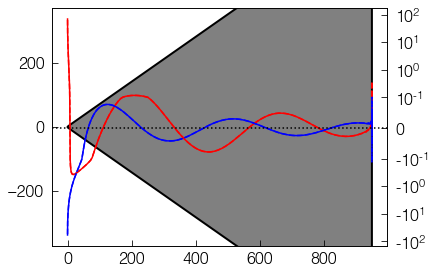

In [9]:
beta=2+1j; Nmodes=20

#-- Solve induced charge directly with boundary element method
Q1=P.solve_induced_charge_direct(Er=Er0,Ez=Ez0,rho=beta)
q1=P.get_charge_density(Q1)

#-- Solve induced charge with eigenoscillation expansion
Q2=P.solve_induced_charge_eigen(Er=Er0,Ez=Ez0,rho=beta, Veff=True, Nmodes=Nmodes)
q2=P.get_charge_density(Q2)


plt.fill_between(x=zsprobe,
                 y1=rsprobe,y2=-rsprobe,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')

ax2=plt.twinx()
q1.real.plot(color='r')
q1.imag.plot(color='b')

q2.real.plot(color='r',ls='--')
q2.imag.plot(color='b',ls='--')

plt.gca().set_yscale('symlog',linthresh=.1)
plt.axhline(0,ls=':',color='k')

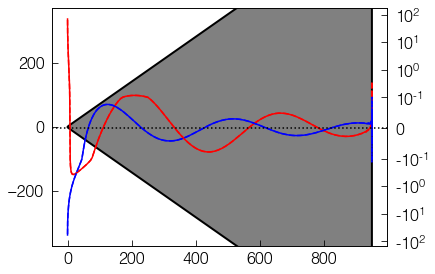

In [10]:
#-- Solve induced charge in a "scattered charge" formalism
Q0=P.solve_induced_charge_direct(Er=Er0,Ez=Ez0,rho=0)
q0=P.get_charge_density(Q0)

rhos=P.get_eigenrhos()
Qs=P.get_eigencharges()

excs=P.get_eigenexcitations(Er=Er0,Ez=Ez0,recompute=True)
dQs=[Q * beta/(rho*(rho-beta)) * exc for rho,exc,Q in zip(rhos,excs,Qs)]
dQ=np.sum(dQs[:Nmodes],axis=0)

Qtest=Q0-dQ
qtest =P.get_charge_density(Qtest)

#---
plt.fill_between(x=zsprobe,
                 y1=rsprobe,y2=-rsprobe,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')
ax2.set_ylim(-1000,1000)

ax2=plt.twinx()
q1.real.plot(color='r')
q1.imag.plot(color='b')

qtest.real.plot(color='r',ls='--')
qtest.imag.plot(color='b',ls='--')
plt.gca().set_yscale('symlog',linthresh=.1)
plt.axhline(0,ls=':',color='k')

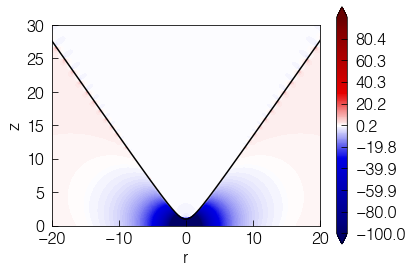

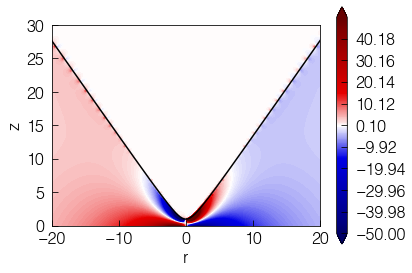

In [11]:
#--- Visualize the scattered E-field (and incident)
#
# Computed in quasistatic approximation from exact electrodynamic charge solution
# Sums incident field with that from the probe & sample (scattered field)

cl=100

at_rs=np.linspace(-20,20,200)
at_zs=np.linspace(0,30,150)
er0 = Er0(at_rs[:,np.newaxis],at_zs[np.newaxis,:])
ez0 = Ez0(at_rs[:,np.newaxis],at_zs[np.newaxis,:])

erScat,ezScat=P.computeEfieldImages(Q1, rho=beta,
                                    rs_out=at_rs, zs_out=at_zs,\
                                    display=True,mirror_double_images=False)

er = er0 + erScat
ez = ez0 + ezScat

plt.figure()
plt.plot(xsprobe,ysprobe+1,color='k')
plt.gca().set_aspect('equal')
ez.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl,cl,500),extend='both')
plt.clim(-cl,cl)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

plt.figure()
plt.plot(xsprobe,ysprobe+1,color='k')
plt.gca().set_aspect('equal')
er.real.plot(plotter=plt.contourf,cmap='BWR',\
             levels=np.linspace(-cl/2,cl/2,500),extend='both')
plt.clim(-cl/2,cl/2)
plt.xlim(-at_rs.max(),at_rs.max())
plt.ylim(0,at_zs.max())
plt.gca().set_aspect('equal')

# Eigenoscillation spectroscopy

In [12]:
from ProbeCavityEigenfields import ProbeSpectroscopy as PS

## Energy spectroscopy

In [13]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

freqs = np.linspace(0,100,150)*freq_THz

@misc.autopickle('ProbeFreqSpectroscopy_taper=%i.pickle'%taper_angle)
def getFreqSpectroscopy(P,freqs = freqs):
    
    Spectroscopy = PS.ProbeSpectroscopyParallel(P, coords=freqs,
                                                eigenset_calculator=PS.compute_eigenset_at_freq,\
                                                ncpus=8, backend='multiprocessing', Nmodes=20, gap=1, PhiM=False)
    Spectroscopy.classify_eigensets(Nmodes=10, reversed=True)
    
    return Spectroscopy

<ProbeSpectroscopy.ProbeSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 150 identifiable mutual coordinates.


Text(0.5, 0, 'Frequency')

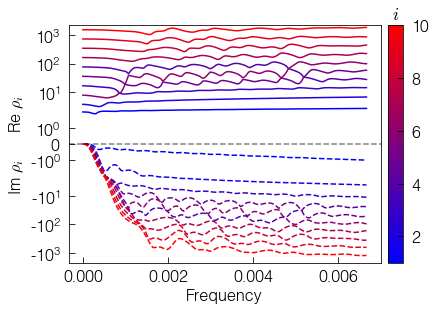

In [14]:
Spectroscopy = getFreqSpectroscopy(P)
Spectroscopy.plot_eigenrhos()
#plt.gcf().axes[0].set_xlim(0,.001)
plt.gcf().axes[0].set_xscale('linear')
plt.gcf().axes[0].set_xlabel('Frequency')

### Kramers-Kronig analysis of eigenvalues

In [151]:
rhos=Spectroscopy.get_eigenrhos_AWA()
print(rhos.axis_names)

<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 150 identifiable mutual coordinates.
['eigenindex', 'coordinate']


Text(0, 0.5, '$1/\\rho_n$')

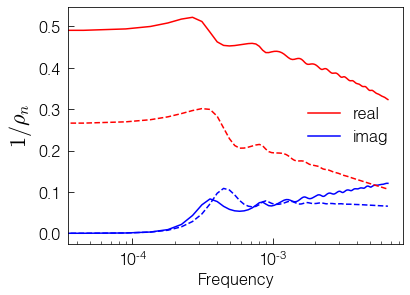

In [152]:
#--- See what some KK-compatible poles look like

(1/rhos[0]).real.plot(color='r',label='real')
(1/rhos[0]).imag.plot(color='b',label='imag')

(1/rhos[1]).real.plot(color='r',ls='--')
(1/rhos[1]).imag.plot(color='b',ls='--')

plt.legend()

plt.gca().set_xscale('log')
plt.xlabel('Frequency')
plt.ylabel(r'$1/\rho_n$',fontsize=22)

In [153]:
#--- Use a model (sum of lorentzians) to fit KK-compatible poles
def model_func(ws,params):
    
    Nosc=(len(params)-1)//3
    
    result=params[0]
    for iosc in range(Nosc):
        a,w1,w2=params[1+iosc*3:1+(iosc+1)*3]
        wresp=np.abs(w1)-1j*np.abs(w2)
        wresm=-np.abs(w1)-1j*np.abs(w2)
        result += np.abs(a)*(w1/(wresp-ws)-w1/(wresm-ws))
    
    return result

from common import numerical_recipes as numrec

In [159]:
#--- Fit this pole
n=0
X=1/rhos[n]

#--- Initial guess
params0=[.3]
for w1 in np.logspace(0,2,10)*.0003:
    params0+=[.05,w1,w1/3]

#--- Nonlinear least-squares (scipy.optimize.leastsq = Levenberg-Marquardt algo.)
result=numrec.ParameterFit(freqs,X,model_func,params0,\
                         limits=None,relative_error=False,\
                         verbose=False,error_exp=4,
                          ftol=1.49012e-12)[0]

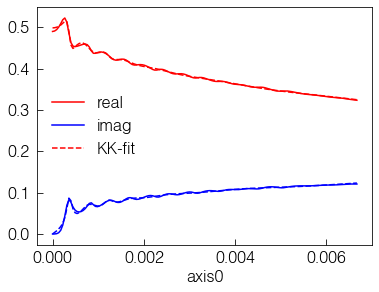

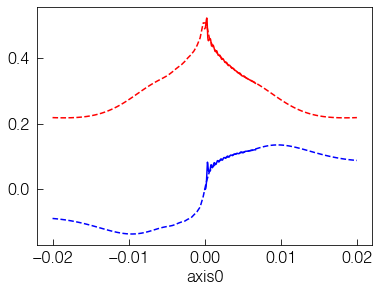

In [160]:
#--- Compare model pole to actual
Xtest=AWA(model_func(freqs,result),axes=[freqs])

X.real.plot(color='r',label='real')
X.imag.plot(color='b',label='imag')

Xtest.real.plot(color='r',ls='--',label='KK-fit')
Xtest.imag.plot(color='b',ls='--')

plt.legend()


plt.figure()
freqs2=np.linspace(-.02,.02,100)
Xtest=AWA(model_func(freqs2,result),axes=[freqs2])

X.real.plot(color='r')
X.imag.plot(color='b')

Xtest.real.plot(color='r',ls='--')
Xtest.imag.plot(color='b',ls='--')

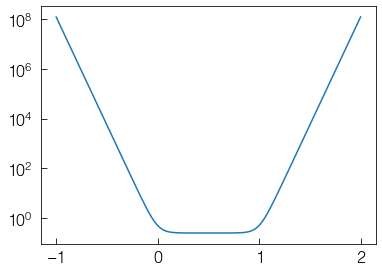

In [128]:
params0=[0.5]
all_window_lims=[[0,1]]
steepness=10

def window_func(params):

    window=1
    for i,param in enumerate(params):
        window_lims=all_window_lims[i]
        span=np.ptp(window_lims)
        x1=(param-np.min(window_lims))/(span/steepness)
        x2=(np.max(window_lims)-param)/(span/steepness)
        g=(1+np.tanh(x1))*(1+np.tanh(x2))
        window*=1/g

    return window

ps=np.linspace(-1,2,100)
plt.semilogy(ps,window_func([ps]))

In [146]:
#--- Fit this eigensusceptibility
n=4
X=1/rhos[n]

#--- Initial guess
params0=[.03]
limits=[None]
for w1 in np.linspace(0,.006,30):
    params0+=[.05,w1,.001/10]
    limits+=[None,(0,.01),None]
    #limits+=[None,None,None]
window_exp=8
    

#--- Nonlinear least-squares (scipy.optimize.leastsq = Levenberg-Marquardt algo.)
print('Round 1')
params=numrec.ParameterFit(freqs,X,model_func,params0,\
                         limits=limits,relative_error=False,\
                         verbose=False,error_exp=1,window_exp=window_exp,
                          ftol=1.49012e-15)[0]

print('Round 2')
params0=params
params=numrec.ParameterFit(freqs,X,model_func,params0,\
                         limits=limits,relative_error=False,\
                         verbose=False,error_exp=2,window_exp=window_exp,
                          ftol=1.49012e-15)[0]

print('Round 3')
params0=params
params=numrec.ParameterFit(freqs,X,model_func,params0,\
                         limits=limits,relative_error=False,\
                         verbose=False,error_exp=3,window_exp=window_exp,
                          ftol=1.49012e-15)[0]

print('Round 4')
params0=params
params=numrec.ParameterFit(freqs,X,model_func,params0,\
                         limits=limits,relative_error=False,\
                         verbose=False,error_exp=1,window_exp=4,
                          ftol=1.49012e-15)[0]

Round 1
Round 2
Round 3
Round 4


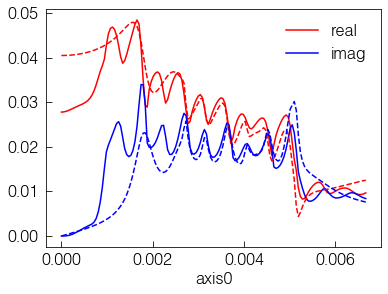

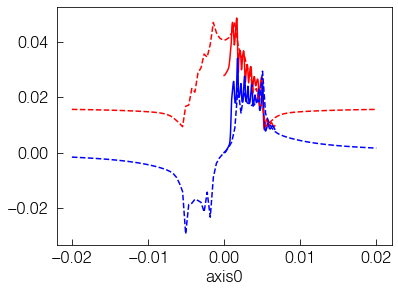

In [147]:
#--- Compare model pole to actual
Xtest=AWA(model_func(freqs,params),axes=[freqs])

X.real.plot(color='r',label='real')
X.imag.plot(color='b',label='imag')

Xtest.real.plot(color='r',ls='--')
Xtest.imag.plot(color='b',ls='--')

plt.legend()


plt.figure()
freqs2=np.linspace(-.02,.02,100)
Xtest=AWA(model_func(freqs2,params),axes=[freqs2])

X.real.plot(color='r')
X.imag.plot(color='b')

Xtest.real.plot(color='r',ls='--')
Xtest.imag.plot(color='b',ls='--')

## Probe-surface gap spectroscopy

In [15]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

gaps = np.logspace(-2,1,150)

@misc.autopickle('ProbeGapSpectroscopy_taper=%i.pickle'%taper_angle)
def getGapSpectroscopy(P, gaps=gaps):
    
    return P.gapSpectroscopy(gaps,Nkappas=244*4,Nmodes=20,
                                        recompute=True)

Starting gap=0.01
Starting gap=0.01
Starting gap=0.011
Starting gap=0.011
Starting gap=0.012
Starting gap=0.013
Starting gap=0.013
Starting gap=0.014
Finished gap=0.013, elapsed time: 0.43 s
Finished gap=0.011, elapsed time: 0.49 s
Finished gap=0.01, elapsed time: 0.51 sFinished gap=0.013, elapsed time: 0.46 s
Finished gap=0.014, elapsed time: 0.44 s

Finished gap=0.011, elapsed time: 0.49 s
Finished gap=0.01, elapsed time: 0.53 s
Finished gap=0.012, elapsed time: 0.5 s
got results!
Starting gap=0.014
Starting gap=0.015
Starting gap=0.016
Starting gap=0.017
Starting gap=0.017
Starting gap=0.018
Starting gap=0.019
Starting gap=0.02
Finished gap=0.016, elapsed time: 0.44 s
Finished gap=0.017, elapsed time: 0.43 s
Finished gap=0.014, elapsed time: 0.47 s
Finished gap=0.015, elapsed time: 0.47 sFinished gap=0.017, elapsed time: 0.43 s

Finished gap=0.018, elapsed time: 0.43 s
Finished gap=0.019, elapsed time: 0.43 s
Finished gap=0.02, elapsed time: 0.41 s
got results!
Starting gap=0.021
St

Starting gap=7.2
Starting gap=7.6
Finished gap=6.6, elapsed time: 0.36 s
Finished gap=5.7, elapsed time: 0.41 sFinished gap=5.5, elapsed time: 0.42 s

Finished gap=6, elapsed time: 0.41 s
Finished gap=6.3, elapsed time: 0.4 s
Finished gap=6.9, elapsed time: 0.39 s
Finished gap=7.2, elapsed time: 0.38 s
Finished gap=7.6, elapsed time: 0.37 s
got results!
Starting gap=7.9
Starting gap=8.3
Starting gap=8.7
Starting gap=9.1
Starting gap=9.5
Starting gap=10
Finished gap=7.9, elapsed time: 0.46 sFinished gap=8.3, elapsed time: 0.44 s

Finished gap=8.7, elapsed time: 0.44 s
Finished gap=9.1, elapsed time: 0.43 sFinished gap=9.5, elapsed time: 0.41 s

Finished gap=10, elapsed time: 0.41 s
got results!
Time elapsed:  14.535869121551514
Classifying eigensets by eigenindex...
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 136 identifiable mutual coordinates.


Text(0.5, 0, 'Gap')

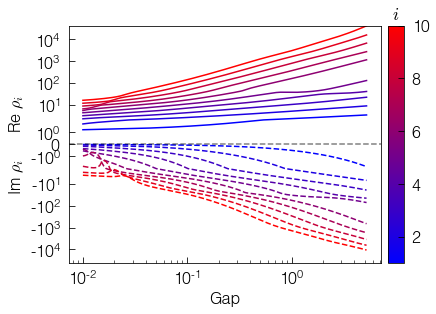

In [17]:
GapSpectroscopy = getGapSpectroscopy(P,recompute=True)
GapSpectroscopy.plot_eigenrhos()
plt.gcf().axes[0].set_xlabel('Gap')

In [18]:
Encoding = PS.EncodedEigenfields(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*4)

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	For Nmodes=20, there were 133 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
<ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding eigenfields to gap=1 across 133 gap values from gap=0.01 to 4.5...
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 9.85E-01...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_brightnesses_AWA>:
	Computing brightnesses across 133 spectroscopy coordinates...


In [19]:
from NearFieldOptics import Materials as M
rp = lambda freq,q: M.SiO2_300nm.reflection_p(freq/(a_nm*1e-7),\
                                              q/(a_nm*1e-7))

at_gaps = np.logspace(-1,.5,50)
freqs=np.linspace(15,50,200)*freq_THz

Erad = [Encoding.EradVsGap(at_gaps=at_gaps, freq=freq, rp=rp) for freq in freqs]
Erad=AWA(Erad,axes=[freqs/freq_THz,at_gaps],axis_names=['Frequency (THz)','Gap'])

<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.Ta

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


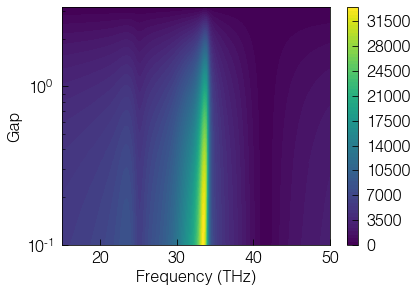

In [20]:
Erad_away = Erad[:,-1][:,np.newaxis]
np.abs(Erad-Erad_away).plot(plotter=plt.contourf)
plt.gca().set_yscale("log")

<>:8: DeprecationWarning: invalid escape sequence \m
<>:8: DeprecationWarning: invalid escape sequence \m
<>:8: DeprecationWarning: invalid escape sequence \m
<ipython-input-21-99ab55514a72>:8: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('$|E_\mathrm{scat}$|',fontsize=20)


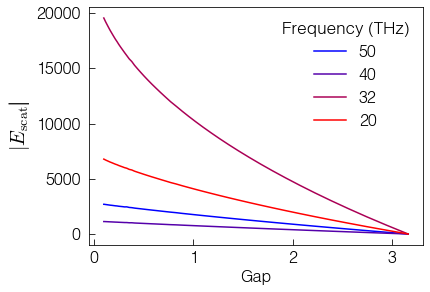

In [21]:
at_freqs = 20,32,40,50
cs=plotting.bluered_colors(len(at_freqs))

for at_freq in at_freqs[::-1]:
    Erad_at_freq=(Erad-Erad[:,-1][:,np.newaxis]).cslice[at_freq]
    np.abs(Erad_at_freq).plot(label=at_freq,color=next(cs))
                                                        
plt.ylabel('$|E_\mathrm{scat}$|',fontsize=20)
plt.legend(title='Frequency (THz)')

In [22]:
signals=Encoding.EradSpectrumDemodulated(freqs, rp=rp,
                                        gapmin=.1, amplitude=1.9,
                                        Ngaps=24*2, demod_order=5)
signals_ref=Encoding.EradSpectrumDemodulated(freqs=P.get_freq(),rp=1,
                                            gapmin=.1, amplitude=1.9,
                                            Ngaps=24*2, demod_order=5)

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


	Computing at freq=1.000E-03...
	Computing at freq=1.012E-03...
	Computing at freq=1.023E-03...
	Computing at freq=1.035E-03...
	Computing at freq=1.047E-03...
	Computing at freq=1.059E-03...
	Computing at freq=1.070E-03...
	Computing at freq=1.082E-03...
	Computing at freq=1.094E-03...
	Computing at freq=1.106E-03...
	Computing at freq=1.117E-03...
	Computing at freq=1.129E-03...
	Computing at freq=1.141E-03...
	Computing at freq=1.152E-03...
	Computing at freq=1.164E-03...
	Computing at freq=1.176E-03...
	Computing at freq=1.188E-03...
	Computing at freq=1.199E-03...
	Computing at freq=1.211E-03...
	Computing at freq=1.223E-03...
	Computing at freq=1.235E-03...
	Computing at freq=1.246E-03...
	Computing at freq=1.258E-03...
	Computing at freq=1.270E-03...
	Computing at freq=1.281E-03...
	Computing at freq=1.293E-03...
	Computing at freq=1.305E-03...
	Computing at freq=1.317E-03...
	Computing at freq=1.328E-03...
	Computing at freq=1.340E-03...
	Computing at freq=1.352E-03...
	Computi

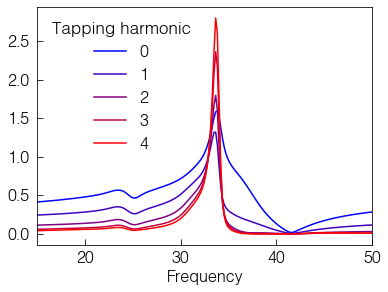

In [23]:
cs=plotting.bluered_colors(5)
for harmonic in range(5):
    normalized=(signals['Sn']/signals_ref['Sn'])[harmonic]
    np.abs(normalized).plot(color=next(cs),
                            label=harmonic)
for l in plt.gca().lines: l.set_xdata(l.get_xdata()/freq_THz)
plt.xlim(15,50)
plt.legend(title='Tapping harmonic')